
# Assignment 1, Plancton classification Andreas Steinvik


## See pdf version to ensure loading of images


In [2]:
from PIL import Image, ImageOps
import glob
import os
import random as rnd
import keras
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Input, Conv2D, GlobalAveragePooling2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import numpy as np
% matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd


Using TensorFlow backend.


### Image Preprocessing

I created a script to run once before starting the training, it splits data into training and validation, increase size of class by mirror and rotation, or decrease the size of class by randomly dropping image if class is larger than wanted.

I used a class size of 8000 for training and 100 for testing. 

for resizing i did:
    1. if image is larger than 299*299 i downscale to max 299 without changing aspect ratio
    2. If image has max dimention < 100 pixels i upscale 4 times before doing step 1.
    3. If image has max dimention < 200 pixels i upscale 2 times before doing step 1.
    4. Then i pad up to 299*299 with white pixels 
    5. convert to rgb by copying same values to all channels
    

#### Example input

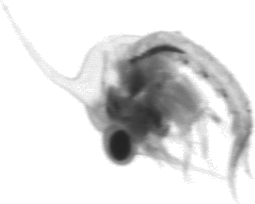

In [24]:

from IPython.display import Image 
Image(filename="imgs/Brachyura/993287.jpg")

In [7]:
# globals for image processing
minw = 10000000
minh = 10000000
minr = 10000000
maxw = 0
maxh = 0
maxr = 0
nTRAIN = 8000
nTEST = 100

In [13]:
def preprocess():
    '''Do preprocessing of images in img directory and create test and train directories'''
    global minw, minh, minr, maxw, maxh, maxr
    
    src_dir = "imgs/"
    dst_dir = "train/"
    test_dir = "test/"
    classes = readClassnames()
    
    for dirs, i in zip(classes,range(len(classes))):

        train_directory=dst_dir+dirs+"/"
        test_directory=test_dir+dirs+"/"
        createDir(train_directory)
        createDir(test_directory)

        n_images=len([name for name in os.listdir(src_dir+dirs) if os.path.isfile(os.path.join(src_dir+dirs, name))])
        print(dirs,n_images)

        size_diff = nTRAIN-n_images
        test_diff = nTEST
        in_trainset = 0
        for mediafile in glob.iglob(src_dir+dirs+"/*.jpg"):

            im=Image.open(mediafile)
            mediafile=mediafile.split("/")
            image=im.copy()
            #print(image.size,mediafile[-1])

            ratio=image.size[0]/image.size[1]
            if(ratio<1):
                image = image.rotate(90,expand=True)

            maxw, maxh, maxr = sizeStats(max,image.size)
            minw, minh, minr = sizeStats(min,image.size)


            if(max(image.size)<100):
                factor=4
                size=(image.size[0]*factor,image.size[1]*factor)
                image=image.resize(size)
            elif(max(image.size)<200):
                factor=2
                size=(image.size[0]*factor,image.size[1]*factor)
                image=image.resize(size)

            maxsize = (299, 299)
            image.thumbnail(maxsize, Image.LANCZOS)
            image = pad(image)
            image = image.convert(mode="RGB")

            if(test_diff>0 and rnd.random()<0.15):
                test_diff-=1
                image.save(test_directory+mediafile[-1],"JPEG")
            else:
                if(size_diff<0 and in_trainset<nTRAIN and rnd.random()<(1.1*nTRAIN/n_images)): #if set is larger than wanted some will be dropped ranomly
                        in_trainset+=1
                        image.save(train_directory+mediafile[-1],"JPEG")

                elif(size_diff>0 and in_trainset<nTRAIN):#if set is smaller than wanted some will be augmented
                    in_trainset+=1
                    image.save(train_directory+mediafile[-1],"JPEG")

                    if(rnd.random()<size_diff/n_images):
                        mirror = ImageOps.mirror(image)
                        in_trainset+=1
                        mirror.save(train_directory+"flip"+mediafile[-1],"JPEG")
                        if(size_diff/n_images>3):
                            mirror =im.rotate(90)
                            in_trainset+=1
                            mirror.save(train_directory+"rotate"+mediafile[-1],"JPEG")
                    if(size_diff/n_images>2):
                        image =im.rotate(90)
                        in_trainset+=1
                        image.save(train_directory+"rotate"+mediafile[-1],"JPEG")


    print("maximum: ","width: ",maxw," height: ",maxh," ratio: ",maxr)
    print("minimum: ","width: ",minw," height: ",minh," ratio: ",minr)


def pad(image):
    '''pad image up to 299*299 with white pixels'''

    goal=299

    padding_width = (goal-image.size[0])//2
    padding_height = (goal-image.size[1])//2

    padding = (padding_width, padding_height, goal-image.size[0]-padding_width, goal-image.size[1]-padding_height)

    image = ImageOps.expand(image, padding, fill=255)
    return image


def readClassnames(filename="Ex1_selected_categories"):
    ''' create list of classnames'''
    classes = []
    with open(filename,"r")as f:
        for line in f:
            classes.append(line.strip())
    return classes

def sizeStats(func,im_size):
    ''' update stats for largest and smalles dimentions and ratio'''
    return (func((maxw,im_size[0])), 
            func((maxh,im_size[1])), 
            func((maxr,(im_size[0]/im_size[1]))))

def createDir(directory):
    '''create class directories'''
    if not os.path.exists(directory):
        os.makedirs(directory)


#### Run Preprocessing with next cell


In [ ]:
preprocess()

## Training model

In [15]:
# globals for model training and testing
train_data_directory="./train/"
test_data_directory="./test/"
image_size=(299,299)
batch_size = 256
CLASSES = 40
EPOCHS = 25
FILENAME = "train_top"
new_model = False
l2_rate = 0.6

#### Creating Generators


In [17]:
def create_generators():
    ''' returns a training generator and a validation generator with flow from directory'''
    train_datagen = ImageDataGenerator(
        preprocessing_function = preprocess_input,
        validation_split=0.1)

    train_generator = train_datagen.flow_from_directory(
        train_data_directory,
        target_size=image_size,
        batch_size=batch_size,
        subset='training') 

    validation_generator = train_datagen.flow_from_directory(
        train_data_directory, 
        target_size=image_size,
        batch_size=batch_size,
        subset='validation') 

    return train_generator , validation_generator

#### Create model


In [18]:
def create_model():
    resNet = ResNet50(weights='imagenet',include_top=False, input_shape=(299,299,3))
    x = resNet.output
    x = GlobalAveragePooling2D()(x)
    #x = Dense(256, activation='relu')(x)
    predictions = Dense(CLASSES, activation='softmax')(x)

    return Model(inputs=resNet.input, outputs=predictions)

 def test_model(model):
    test_gen = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(
        test_data_directory,
        target_size=image_size,
        batch_size=batch_size)
    score = model.evaluate_generator(
                    test_gen,
                    steps=test_gen.samples // batch_size,
                    use_multiprocessing=True)

    print('loss:',score[0])
    print('accuracy:',score[1])
    np.set_printoptions(threshold=np.inf)
    print(conf_matrix(model))

def conf_matrix(model):
    test_gen = ImageDataGenerator(preprocessing_function = preprocess_input).flow_from_directory(
        test_data_directory,
        target_size=image_size,
        batch_size=batch_size)

    n = 3600
    X = []
    y = []
    for d, l in test_gen:
        X.append(d)
        y.append(l)
        n -=batch_size
        if n < 1:
            break

    X = np.array(X)
    X = np.reshape(X, (X.shape[0]*X.shape[1],) + X.shape[2:])
    y = np.array(y)
    y = np.reshape(y, (y.shape[0]*y.shape[1],) + y.shape[2:])

    conf_matrix = np.zeros((40,40),dtype= int)
    n = 0
    y_pred = model.predict(X)
    for xi,yi,img in zip(y_pred,y,X):
            pred = int(np.argmax(xi))
            corr = int(np.argmax(yi))
            if pred != corr and n < 6:
                n+=1
            conf_matrix[pred][corr]+=1
    return conf_matrix

def save_model(model, name):
    with open(name+'.json','w') as f:
        f.write(model.to_json())
    model.save_weights(name+'.h5')


def load_model(name):
    with open(name+'.json','r') as f:
        model = model_from_json(f.read())
    model.load_weights("2604"+'.h5')
    return model


def lock_layers(model):
    n = 22
    for layer in model.layers[:-n]:
        layer.trainable = False
    for layer in model.layers[-n:]:
        layer.trainable = True
    for l in [1,6,9,12,16,19,22]:
        model.layers[-l].kernel_regularizer = l2(l2_rate) 
        model.layers[-l].activation_regularizer = l2(l2_rate)
    return model

#### cross validation for l2 value

In [29]:

def CV_l2(train_gen,valid_gen):
    accuracy = []
    for l2 in [x * 0.1 for x in range(0, 20)]:
        model = load_model(FILENAME)
        model = lock_layers(model,l2_value=l2)
        model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit_generator(
                train_gen,
                steps_per_epoch = train_gen.samples // (15*batch_size),
                verbose = 1,
                use_multiprocessing=True,
                epochs = 5)
        score = model.evaluate_generator(valid_gen,
                    steps=valid_gen.samples // (10*batch_size))
        accuracy.append(score[1])
    print(accuracy)


#### Plot training accuracy and loss


In [19]:
def plot_history(history):
    plt.figure(1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    #plt.savefig(FILENAME+'_'+'acc_plot'+'.png')
    #plt.show()


    plt.figure(2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    #plt.savefig(FILENAME+'_'+'loss_plot'+'.png')
    plt.show()

#### main

In [ ]:
train_gen,valid_gen = create_generators()
if (new_model):
    model = create_model()
else:
    model = load_model(FILENAME)


model = lock_layers(model)
model.summary()

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
stopping = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("checkpoint_reg.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)
#history = model.fit_generator(
#        train_gen,
#        steps_per_epoch = train_gen.samples // (8*batch_size),
#        validation_data = valid_gen, 
#        validation_steps = valid_gen.samples // (7*batch_size),
#        verbose = 1,
#        callbacks = [checkpoint,stopping],
#        use_multiprocessing=True,
#        epochs = EPOCHS)

save_model(model, FILENAME)
test_model(model)
confusion_matrix(model,X,y):
#plot_history(history)


## Report

I used the Resnet50 models from Keras with weights from imageNet. I had a really hard time trying to get the accuracy over 20 % for the validation and test set. I suspected heavy overfit since the training accuracy got up to over 80 %, so I implemented L2_regularization for the trainable layers. I started with training only the top layer, and then opened more and more layers until I trained the last 50 % of the model. This gave increasing accuracy until i opened over 25 layers, then I never could get the accuracy over 15 % no matter how much i trained.

For the regularisation I ran a light cross validation test for many values between 0 and 2 with short epochs. The best results came with regularization of 0.6 so that was the value used in final training.

My final best accuracy was 26%. As seen from the confusion matrix below, the accuracy was very bad for all classes (predicted class in rows and correct class in column). The matrix shows that alot of the pictures got predicted as class 14. This corresponds to eggs__other, a class with very difuse images of circular things. If I had tried to do a full training run of the other 39 classes I may have gotten a fair bit better results.

#### Confusion matrix

Rows is number of predicted class, columns is correct class

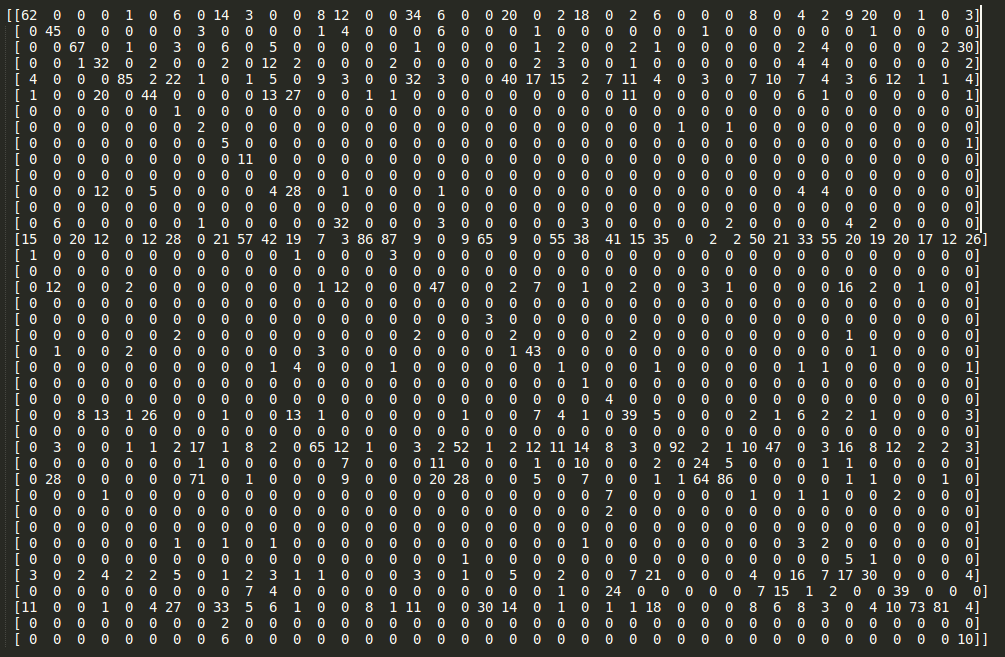

In [27]:
Image(filename="conf_matrix.png")

#### Accuracy plot showing large degree of overfitting

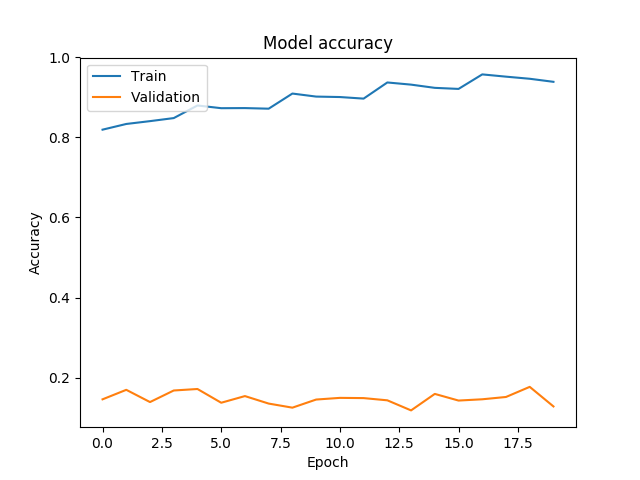

In [28]:
Image(filename="train_top_acc_plot.png")

## Optional task C

As I had trouble getting a high accuracy for the full model because of overfitting i hoped the smaller model could get the same or even better, but I tried both 33 layers and 15, but both got around 10% with almost as mush overfit as the full model, which I dont understand.

The time each used to train one step with batch size of 256 was 2 seconds for all models at its best, but had quite a lot of variation with the same model, which I suspect is because the main bottleneck is the generator getting the pictures and not the GPU training run itself.

The space taken on the other hand was very different:
while the full ResNet50 has 95MB weights and 23mill parameters.
The model with the first 15 layers only had 832,424 parameters and 3,5MB weights.
The model with the first 33 layers only had 6,088,616 parameters and 24,6MB weights.

In [ ]:
def create_model():
resNet = ResNet50(weights='imagenet',include_top=False, input_shape=(299,299,3))
x = resNet.get_layer('activation_15').output
x = GlobalAveragePooling2D()(x)
#x = Dense(256, activation='relu')(x)
predictions = Dense(CLASSES, activation='softmax')(x)

return Model(inputs=resNet.input, outputs=predictions)

## Future work

For future work I would have first tried to lower the importance of the eggs__other class to see how much that would affect the accuracy. I would also try to fix the problem with not getting as high accuracy if training more than 30 layers. I guess just training for a longer time before opening a new layer could help with this. I would also try to implement dropout, which i could not get to work with the pretrained model now.